**Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
%matplotlib inline
# remove warnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


**Dataset**

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [4]:
# our dataset is in cocoformat, we will need pypcoco tools
from pycocotools.coco import COCO

# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [5]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [6]:
class HelmetDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [7]:
dataset_path = r"/Helmet Detection/data"

In [8]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=4.55s)
creating index...
index created!


{0: {'id': 0, 'name': 'rider-helmet-bike', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'With Helmet', 'supercategory': 'rider-helmet-bike'},
 2: {'id': 2, 'name': 'Without Helmet', 'supercategory': 'rider-helmet-bike'}}

In [9]:
classes = [i[1]['name'] for i in categories.items()]
classes

['rider-helmet-bike', 'With Helmet', 'Without Helmet']

In [10]:
len(classes)

3

In [11]:
train_dataset = HelmetDetection(root=dataset_path, transforms=get_transforms(True))
print(f'Total Training Samples: ', len(train_dataset))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Total Training Samples:  1182


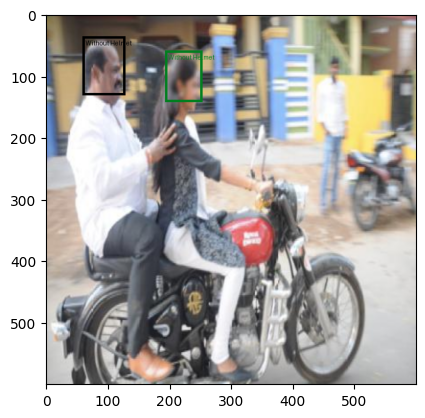

In [12]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

**Model**

Our model is FasterRCNN with a backbone of MobileNetV3-Large. We need to change the output layers because we have just 6 classes but this model was trained on 90 classes.

In [13]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 190MB/s]


This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [18]:
# !pip install dill

In [19]:
import os
import sys
import dill

def save_object(file_path: str, obj: object) -> None:
    logging.info("Entered the save_object method of utils")

    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, "wb") as file_obj:
        dill.dump(obj, file_obj)

    logging.info("Exited the save_object method of utils")

def load_object(file_path: str) -> object:
    logging.info("Entered the load_object method of utils")

    with open(file_path, "rb") as file_obj:
        obj = dill.load(file_obj)

    logging.info("Exited the load_object method of utils")

    return obj

The following blocks ensures that the model can take in the data and that it will not crash during training

In [20]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [22]:
model = model.to(device)

In [31]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [23]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

**Training**

In [24]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [25]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 296/296 [04:08<00:00,  1.19it/s]


Epoch 0, lr: 0.010000, loss: 0.579466, loss_classifier: 0.262195, loss_box: 0.293666, loss_rpn_box: 0.005129, loss_object: 0.018477


100%|██████████| 296/296 [00:43<00:00,  6.74it/s]


Epoch 1, lr: 0.010000, loss: 0.584696, loss_classifier: 0.260128, loss_box: 0.311394, loss_rpn_box: 0.004003, loss_object: 0.009171


100%|██████████| 296/296 [00:42<00:00,  6.90it/s]


Epoch 2, lr: 0.010000, loss: 0.608632, loss_classifier: 0.248089, loss_box: 0.349688, loss_rpn_box: 0.003588, loss_object: 0.007267


100%|██████████| 296/296 [00:42<00:00,  6.92it/s]


Epoch 3, lr: 0.010000, loss: 0.579587, loss_classifier: 0.228857, loss_box: 0.340875, loss_rpn_box: 0.003372, loss_object: 0.006483


100%|██████████| 296/296 [00:42<00:00,  6.98it/s]


Epoch 4, lr: 0.010000, loss: 0.588905, loss_classifier: 0.219223, loss_box: 0.360781, loss_rpn_box: 0.003127, loss_object: 0.005774


100%|██████████| 296/296 [00:42<00:00,  7.04it/s]


Epoch 5, lr: 0.010000, loss: 0.559501, loss_classifier: 0.206484, loss_box: 0.344421, loss_rpn_box: 0.003022, loss_object: 0.005575


100%|██████████| 296/296 [00:42<00:00,  7.03it/s]


Epoch 6, lr: 0.010000, loss: 0.552083, loss_classifier: 0.207093, loss_box: 0.336563, loss_rpn_box: 0.002934, loss_object: 0.005494


100%|██████████| 296/296 [00:41<00:00,  7.13it/s]


Epoch 7, lr: 0.010000, loss: 0.542450, loss_classifier: 0.195030, loss_box: 0.339163, loss_rpn_box: 0.002908, loss_object: 0.005349


100%|██████████| 296/296 [00:42<00:00,  6.95it/s]


Epoch 8, lr: 0.010000, loss: 0.537660, loss_classifier: 0.185806, loss_box: 0.344357, loss_rpn_box: 0.002788, loss_object: 0.004709


100%|██████████| 296/296 [00:42<00:00,  7.02it/s]


Epoch 9, lr: 0.010000, loss: 0.564203, loss_classifier: 0.190801, loss_box: 0.366005, loss_rpn_box: 0.002733, loss_object: 0.004663


In [32]:
# Save model weights
torch.save(model, "/content/fastrcnn_model.pt")

**Inference**

In [26]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [27]:
test_dataset = HelmetDetection(root=dataset_path, split="test", transforms=get_transforms(False))
print(f'Total Training Samples: ', len(train_dataset))

loading annotations into memory...
Done (t=1.46s)
creating index...
index created!
Total Training Samples:  1182


In [28]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [29]:
prediction

[{'boxes': tensor([[489.9817, 136.4478, 524.7956, 200.2069],
          [217.0466,  97.9679, 261.2385, 176.4231],
          [451.6902, 134.2599, 488.0241, 188.6863],
          [348.4711, 148.3984, 389.2166, 222.7959],
          [179.8956, 137.3932, 216.7845, 192.4980],
          [218.8886,  97.2363, 260.7504, 172.9177],
          [348.8993, 147.4239, 386.1033, 225.9932]], device='cuda:0'),
  'labels': tensor([2, 1, 2, 1, 1, 2, 2], device='cuda:0'),
  'scores': tensor([0.9956, 0.9768, 0.9616, 0.7972, 0.2996, 0.1070, 0.0945],
         device='cuda:0')}]

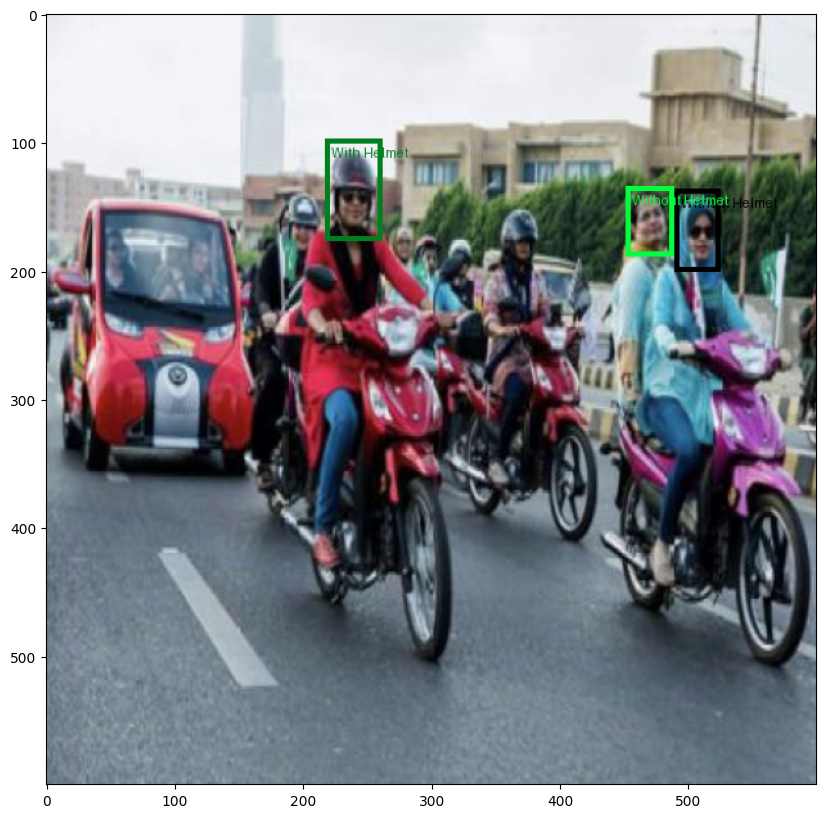

In [30]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

**Prediction**

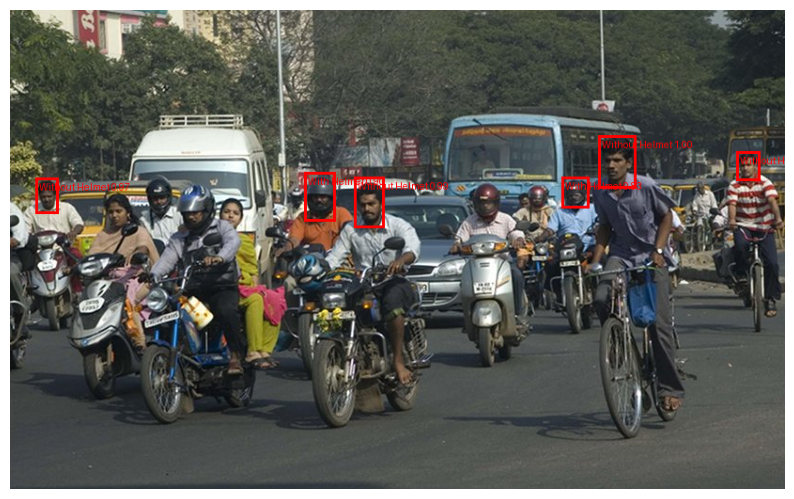

In [47]:
import torch
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class labels (modify as per your dataset)
classes = ['rider-helmet-bike', 'With Helmet', 'Without Helmet']

# Load the model
model = torch.load(r"/content/fastrcnn_model.pt", map_location=device)
model.to(device)
model.eval()

# Load and preprocess the image
img = Image.open(r"/content/drive/MyDrive/Generative AI/Object Detection/Helmet Detection/data/pic1.jpg").convert("RGB")

# Convert image to tensor
transform = transforms.ToTensor()
img_tensor = transform(img).to(device)

# Convert image to uint8 format for visualization
img_int = (img_tensor * 255).byte()

# Perform inference
with torch.no_grad():
    prediction = model([img_tensor])

# Get predictions
pred = prediction[0]
confidence_threshold = 0.8

# Filter predictions based on confidence score
mask = pred['scores'] > confidence_threshold
boxes = pred['boxes'][mask]
labels = pred['labels'][mask].tolist()
scores = pred['scores'][mask]

# Draw bounding boxes
img_with_boxes = draw_bounding_boxes(
    img_int.cpu(),  # Convert to CPU for visualization
    boxes.cpu(),
    [f"{classes[i]} {s:.2f}" for i, s in zip(labels, scores)],
    colors="red",
    width=3
)

# Convert to HWC format for visualization
img_with_boxes = img_with_boxes.permute(1, 2, 0)

# Plot the image with bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(img_with_boxes)
plt.axis("off")
plt.show()

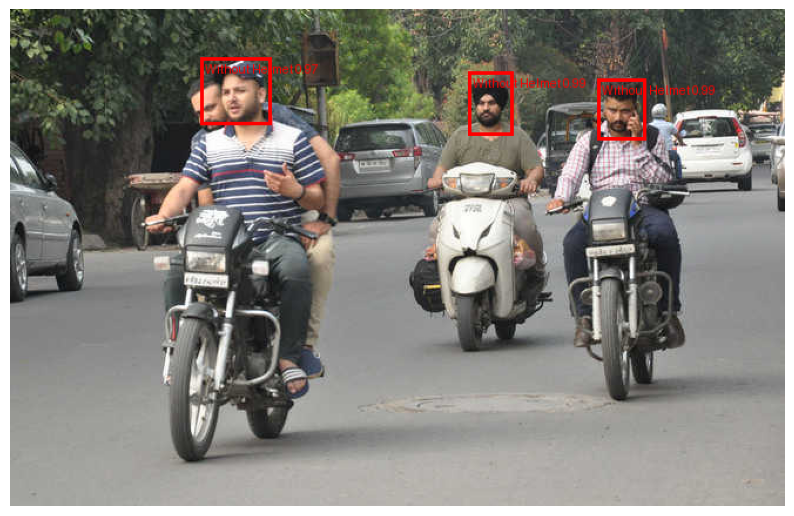

In [42]:
import torch
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class labels (modify as per your dataset)
classes = ['rider-helmet-bike', 'With Helmet', 'Without Helmet']

# Load the model
model = torch.load(r"/content/fastrcnn_model.pt", map_location=device)
model.to(device)
model.eval()

# Load and preprocess the image
img = Image.open(r"/content/drive/MyDrive/Generative AI/Object Detection/Helmet Detection/data/pic2.jpg").convert("RGB")

# Convert image to tensor
transform = transforms.ToTensor()
img_tensor = transform(img).to(device)

# Convert image to uint8 format for visualization
img_int = (img_tensor * 255).byte()

# Perform inference
with torch.no_grad():
    prediction = model([img_tensor])

# Get predictions
pred = prediction[0]
confidence_threshold = 0.8

# Filter predictions based on confidence score
mask = pred['scores'] > confidence_threshold
boxes = pred['boxes'][mask]
labels = pred['labels'][mask].tolist()
scores = pred['scores'][mask]

# Draw bounding boxes
img_with_boxes = draw_bounding_boxes(
    img_int.cpu(),  # Convert to CPU for visualization
    boxes.cpu(),
    [f"{classes[i]} {s:.2f}" for i, s in zip(labels, scores)],
    colors="red",
    width=3
)

# Convert to HWC format for visualization
img_with_boxes = img_with_boxes.permute(1, 2, 0)

# Plot the image with bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(img_with_boxes)
plt.axis("off")
plt.show()

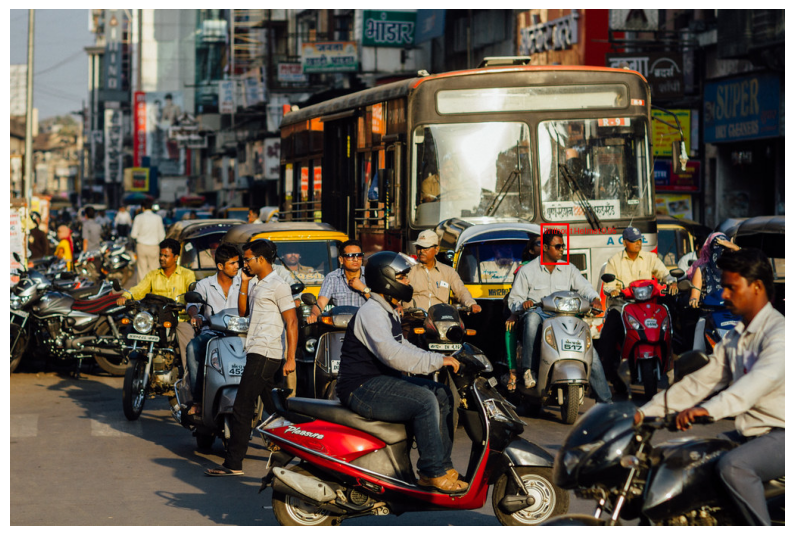

In [48]:
import torch
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class labels (modify as per your dataset)
classes = ['rider-helmet-bike', 'With Helmet', 'Without Helmet']

# Load the model
model = torch.load(r"/content/fastrcnn_model.pt", map_location=device)
model.to(device)
model.eval()

# Load and preprocess the image
img = Image.open(r"/content/drive/MyDrive/Generative AI/Object Detection/Helmet Detection/data/pic3.jpg").convert("RGB")

# Convert image to tensor
transform = transforms.ToTensor()
img_tensor = transform(img).to(device)

# Convert image to uint8 format for visualization
img_int = (img_tensor * 255).byte()

# Perform inference
with torch.no_grad():
    prediction = model([img_tensor])

# Get predictions
pred = prediction[0]
confidence_threshold = 0.8

# Filter predictions based on confidence score
mask = pred['scores'] > confidence_threshold
boxes = pred['boxes'][mask]
labels = pred['labels'][mask].tolist()
scores = pred['scores'][mask]

# Draw bounding boxes
img_with_boxes = draw_bounding_boxes(
    img_int.cpu(),  # Convert to CPU for visualization
    boxes.cpu(),
    [f"{classes[i]} {s:.2f}" for i, s in zip(labels, scores)],
    colors="red",
    width=3
)

# Convert to HWC format for visualization
img_with_boxes = img_with_boxes.permute(1, 2, 0)

# Plot the image with bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(img_with_boxes)
plt.axis("off")
plt.show()

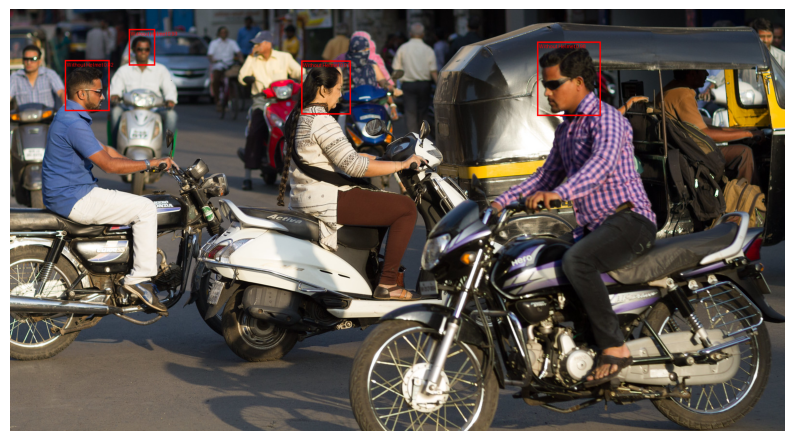

In [49]:
import torch
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class labels (modify as per your dataset)
classes = ['rider-helmet-bike', 'With Helmet', 'Without Helmet']

# Load the model
model = torch.load(r"/content/fastrcnn_model.pt", map_location=device)
model.to(device)
model.eval()

# Load and preprocess the image
img = Image.open(r"/content/drive/MyDrive/Generative AI/Object Detection/Helmet Detection/data/pic4.jpg").convert("RGB")

# Convert image to tensor
transform = transforms.ToTensor()
img_tensor = transform(img).to(device)

# Convert image to uint8 format for visualization
img_int = (img_tensor * 255).byte()

# Perform inference
with torch.no_grad():
    prediction = model([img_tensor])

# Get predictions
pred = prediction[0]
confidence_threshold = 0.8

# Filter predictions based on confidence score
mask = pred['scores'] > confidence_threshold
boxes = pred['boxes'][mask]
labels = pred['labels'][mask].tolist()
scores = pred['scores'][mask]

# Draw bounding boxes
img_with_boxes = draw_bounding_boxes(
    img_int.cpu(),  # Convert to CPU for visualization
    boxes.cpu(),
    [f"{classes[i]} {s:.2f}" for i, s in zip(labels, scores)],
    colors="red",
    width=3
)

# Convert to HWC format for visualization
img_with_boxes = img_with_boxes.permute(1, 2, 0)

# Plot the image with bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(img_with_boxes)
plt.axis("off")
plt.show()

In [33]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda") # use GPU to train

classes = ['vehicles', 'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

model = torch.load(r"/content/fastrcnn_model.pt")

model.eval()

img = Image.open(r"/content/drive/MyDrive/Generative AI/Object Detection/Helmet Detection/data/pic1.jpg")

convert_tensor = transforms.ToTensor()

img1 = convert_tensor(img)

img_int = torch.tensor(img1*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img1.to(device)])
    pred = prediction[0]

bbox_tensor = draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(0, 2, 1)

In [34]:
bbox_tensor

tensor([[[253, 253, 254,  ..., 248, 249, 250],
         [253, 253, 254,  ..., 247, 248, 249],
         [253, 253, 254,  ..., 248, 249, 250],
         ...,
         [227, 237, 199,  ..., 215, 215, 215],
         [220, 236, 152,  ..., 216, 216, 216],
         [225, 220, 135,  ..., 216, 216, 216]],

        [[255, 255, 255,  ..., 203, 202, 201],
         [255, 255, 255,  ..., 205, 203, 202],
         [255, 255, 255,  ..., 206, 204, 203],
         ...,
         [223, 231, 184,  ..., 204, 204, 204],
         [209, 223, 135,  ..., 205, 205, 205],
         [208, 200, 110,  ..., 205, 205, 205]],

        [[245, 245, 245,  ..., 208, 208, 207],
         [245, 245, 245,  ..., 209, 208, 208],
         [245, 245, 245,  ..., 210, 209, 209],
         ...,
         [185, 195, 155,  ..., 198, 198, 198],
         [177, 191, 109,  ..., 199, 199, 199],
         [180, 175,  90,  ..., 199, 199, 199]]], dtype=torch.uint8)

In [35]:
transform = transforms.ToPILImage()
img = transform(bbox_tensor)
type(img)

PIL.Image.Image

In [39]:
# Converting image into base64

import base64
from io import BytesIO

buffered = BytesIO()
img.save(buffered, format="JPEG")
img_str = base64.b64encode(buffered.getvalue())
img_str

b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEtAKcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD36sDxNPrcFnb/ANjorytMFkbZu2r64/nW9QayGjldJ1HWEvLW2vbPfFMx3XP907C2MfXiugWRv7Qli/hWFGX6ksD/ACFZGt68ul6hpNpsR3vbkRtu/gXIGfrllrRZtuvxJ/z0tpP/AB1k/wDi6IJpDk7u9i3JFFN99N39Ki

**Visualization**

In [ ]:
data = pd.read_csv(r"/content/loss.csv")
data.head()

In [ ]:
data.describe()

In [ ]:
data.describe().mean()

In [ ]:
data.plot()